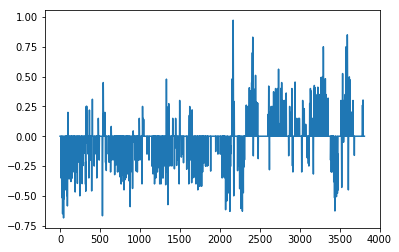

In [53]:
onServer = True

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

LOG_DIR = '/Users/tempflip/Desktop/rec2/'
SERVER_LOG_DIR = '/home/carnd/rec2/'
LOG_FILE  = 'driving_log.csv'
log = []

if onServer : dr = SERVER_LOG_DIR
else : dr = LOG_DIR

with open(dr + '/' + LOG_FILE, 'r') as f:
    reader = csv.reader(f)
    log = pd.DataFrame([row for row in reader], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

#print(log[['CENTER', 'STEERING']])
plt.plot(log['STEERING'])


In [54]:
from scipy import misc
im_list = []
steering_targets = []
STEERING_ADJUST = 0.1

data_list = []

for i in range(len(log['CENTER'].values)):
    c, l, r = log[['CENTER', 'LEFT', 'RIGHT']].values[i]
    if onServer : 
        c = c.replace(LOG_DIR, SERVER_LOG_DIR)
        l = l.replace(LOG_DIR, SERVER_LOG_DIR)
        r = r.replace(LOG_DIR, SERVER_LOG_DIR)
    
    data_list.append((c, log['STEERING'].values[i]))
    
    # center camera
    #im = misc.imread(c)
    #im_list.append(im)
    #steering_targets.append(log['STEERING'].values[i])

    
    # left camera
    #im = misc.imread(l) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) + STEERING_ADJUST)    
    # right camera
    # left camera
    #im = misc.imread(r) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) - STEERING_ADJUST)  
    
#im_list = np.array(im_list, dtype=np.float32)
#steering_targets = np.array(steering_targets, dtype=np.float32)

#assert(steering_targets.shape[0] == im_list.shape[0])

print (len(data_list), 'points')



3812 points


In [55]:
# the generator
def generator(point_list, batch_size=100):  
    while 1:
        point_list = shuffle(point_list)
        X, Y = [], []
        
        for i in range(batch_size):
            path, angle = point_list[i]
            angle = float(angle)
            im = misc.imread(path)
            
            im_flip, angle_flip = flip(im, angle)
            
            X.append(im)
            X.append(np.fliplr(im))
            Y.append(angle)
            Y.append(angle * -1)
            
        yield np.array(X, dtype=np.float32), np.array(Y)



In [56]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

def crop(d):
    return d[:,60:120,:,:]

def normalize(d):
    return d / 255 - 0.5



model = Sequential()

model.add(Lambda(normalize, input_shape=(160, 320, 3)))
model.add(Lambda(crop))


model.add(Convolution2D(9,3,3, border_mode="same"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Convolution2D(18,3,3, border_mode="same"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(10))
model.add(Dense(1))

#print(model.inputs)
print(model.outputs)




[<tf.Tensor 'add_406:0' shape=(?, 1) dtype=float32>]


In [59]:
gen = generator(data_list, batch_size=100)
val_gen = generator(data_list, batch_size=50)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch = 1000, nb_epoch=15, validation_data=val_gen, nb_val_samples=50)


Epoch 1/15
1000/1000 [==============================] - 2s - loss: 0.1639 - acc: 0.5690 - val_loss: 0.1436 - val_acc: 0.6200
Epoch 2/15
1000/1000 [==============================] - 1s - loss: 0.0795 - acc: 0.6630 - val_loss: 0.0337 - val_acc: 0.6400
Epoch 3/15
1000/1000 [==============================] - 1s - loss: 0.0397 - acc: 0.7070 - val_loss: 0.0370 - val_acc: 0.6900

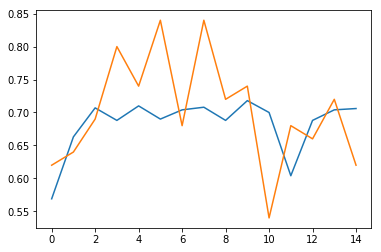

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [61]:
model.save('/home/carnd/my_model.h5')
#model.save('/my_model.h5')
print("Saved.")

Saved.
